In [11]:
! pip install gym-anytrading
! pip install gym numpy stable-baselines3


info: {'total_reward': 27.89616584777832, 'total_profit': 0.989812615901, 'position': <Positions.Long: 1>}


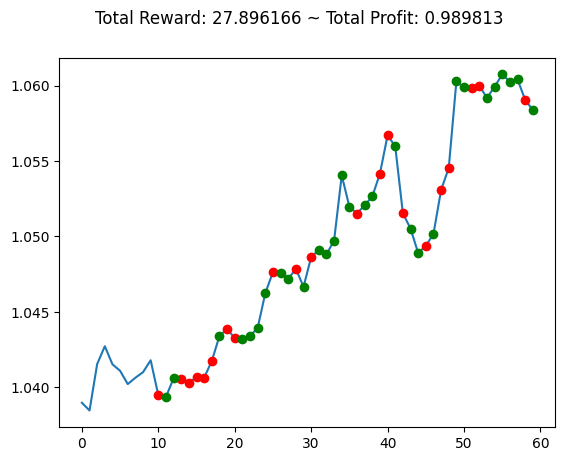

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3 import DQN  # or PPO, A2C, etc.


env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

In [37]:
def my_process_data(env):
    start = max(0, env.frame_bound[0] - env.window_size)  # Ensure start is not negative
    end = min(env.frame_bound[1], len(env.df) - 1)  # Prevent end from exceeding dataset size

    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]

    # Ensure the sliced data has enough length for the window size
    if len(prices) < env.window_size:
        raise ValueError(f"Processed data length {len(prices)} is smaller than window size {env.window_size}")

    return prices, signal_features

class MyForexEnv(ForexEnv):
    _process_data = my_process_data


In [38]:
data_length = len(FOREX_EURUSD_1H_ASK)
print(f"Dataset length: {data_length}")  # Ensure this matches frame_bound limits

env = MyForexEnv(
    df=FOREX_EURUSD_1H_ASK,
    window_size=12,
    frame_bound=(12, min(data_length - 1, 6200))  # Ensure frame_bound[1] is valid
)




Dataset length: 6225


In [39]:
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Stopping: Attempted to access index 6200, which exceeds data size 6200


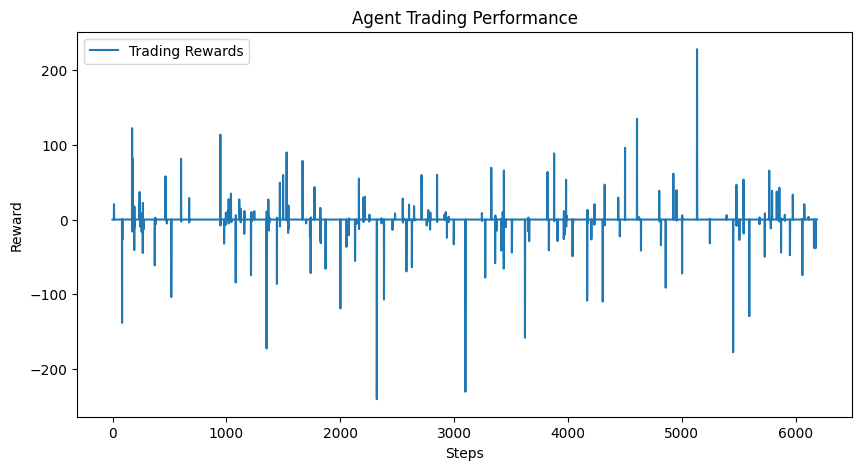

In [41]:
obs, _ = env.reset()
expected_shape = (12, 4)

done = False
rewards = []

while not done:
    # Ensure `obs` is correctly shaped
    if obs.shape != expected_shape:
        if obs.shape[0] < 12:
            obs = np.vstack([np.zeros((12 - obs.shape[0], obs.shape[1])), obs])
        elif obs.shape[0] > 12:
            obs = obs[-12:]

    action, _ = model.predict(obs)

    # Prevent `env.step(action)` from running if out-of-bounds
    if env._current_tick >= len(env.prices):
        print(f"Stopping: Attempted to access index {env._current_tick}, which exceeds data size {len(env.prices)}")
        break

    result = env.step(action)

    if len(result) == 4:
        obs, reward, done, info = result
    elif len(result) == 5:
        obs, reward, done, truncated, info = result
    else:
        raise ValueError(f"Unexpected number of values returned by env.step(): {len(result)}")

    rewards.append(reward)

# 📊 **Plot Final Trading Performance**
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Trading Rewards")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Agent Trading Performance")
plt.legend()
plt.show()


In [27]:
data_length = len(FOREX_EURUSD_1H_ASK)
print(f"Dataset length: {data_length}")  # Ensure this matches frame_bound limits


Dataset length: 6225


In [22]:
data_length = len(FOREX_EURUSD_1H_ASK)
print(f"Dataset length: {data_length}")  # Ensure this matches frame_bound limits


Dataset length: 6225
